## Description Of The Method

---

In this notebook, we present a new direction for increasing the interpretability of Deep Neural Networks (DNNs) by proposing to replace the linear transforms in DNNs by the **B-cos transform**.

The B-cos transform is designed to be compatible with existing architectures and
we show that it can easily be integrated into common models such as *VGGs*, *ResNets*, *InceptionNets*, and *DenseNets*, whilst maintaining similar performance.

---

### The B-cos Transform

---

Typically, the individual neurons in a DNN compute the dot product between their weights **w** and an input **x**:

`f(x; w) = wᵀ x = ||w|| ||x|| c(x, w) with c(x, w) = cos(∠(x, w)).`

Here, `∠(x, w)` returns the angle between the vectors **x** and **w**.

In this work, we seek to improve the interpretability of DNNs by promoting weight-input alignment during optimisation.

To achieve this, we propose the **B-cos transform**:

`B-cos(x; w) = ||ŵ|| ||x|| |c(x, ŵ)|ᴮ × sgn (c(x, ŵ)).`

Here, *B* is a hyperparameter, the hat-operator scales **ŵ** to unit norm, and `sgn` denotes the *sign* function.

Note that this only introduces minor changes with respect to the first equation; e.g., for *B* = 1, the B-cos transform is equivalent to a linear transform with **ŵ**.

These changes maintain an important property of the linear transform: similar to sequences of linear transforms, sequences of B-cos transforms can still be faithfully summarised by a single linear transform.

---

### B-cos Networks

---

The B-cos transform is designed as a *drop-in* replacement of the linear transform, i.e., it can be used in exactly the same way.

For example, a conventional fully connected multi-layer neural network f(**x**; θ) of L layers, is represented by:

`f(x; θ) = lL ◦ lL−1 ◦ ... ◦ l2 ◦ l1(x),`

with lⱼ denoting layer j with parameters **w**ᵏⱼ for neuron k in layer j, and θ the collection of all model parameters.

In such a model, each layer lⱼ typically computes:

`lⱼ(aⱼ; Wⱼ) = φ(Wⱼ aⱼ),`

with aⱼ the input to layer j, φ a non-linear activation function (e.g., ReLU), and the row k of Wⱼ given by the weight vector **w**ᵏⱼ of the k-th neuron in that layer.

A corresponding **B-cos network** f with layers lⱼ can be formulated in exactly the same way, with the only difference being that every dot product (here between rows of Wⱼ and the input aⱼ) is replaced by the B-cos transform.

In matrix form, this equates to:

`lⱼ(aⱼ; Wⱼ) = |c(aⱼ; Ŵⱼ)|^(B-1) × (Ŵⱼ aⱼ)`,`

Here, the power, absolute value, and `×` operators are applied element-wise, `c(aⱼ; Ŵⱼ)` computes the cosine similarity between input aⱼ and the rows of Ŵⱼ, and the hat operator scales the rows of Ŵⱼ to unit norm.

Finally, note that for *B* > 1 the layer transform lⱼ is non-linear.
As a result, a non-linearity φ is not required for a B-cos network to model non-linear relationships.

---

### MaxOut To Increase Modelling Capacity

---

As discussed, a deep B-cos network with *B* > 1 does not require a non-linearity between subsequent layers to model non-linear relationships.
This, of course, does not mean that it could not benefit from it.

In this work, we specifically explore the option of combining the B-cos
transform with the MaxOut operation.
In particular, we model every neuron in a B-cos network by 2 B-cos transforms of which the maximal activation is forwarded:

`MaxOut(x) = max{B-cos(x; wᵢ)} with i∈{1,2}`,

We noticed that networks with the MaxOut operation were much easier to optimise with respect to the ReLU operation.

---

### Advanced B-cos Networks

---

To test the generality of this approach, we evaluate how integrating the B-cos transform into commonly used DNN architectures affects their classification performance and interpretability.

In order to "convert" such models to B-cos networks we proceed as follows:

*   First, every convolutional kernel / fully connected layer is replaced by the corresponding B-cos version with two MaxOut units.

*   Secondly, any other non-linearities (e.g., ReLU, MaxPool, etc.), as well as any batch norm layers are removed to maintain the alignment pressure and to ensure that the model can be summarised via a single linear transform.

---

### Models

---

For the experiments, we rely on the publicly available implementations of the VGG-11, ResNet-34, InceptionNet (v3), and DenseNet-121 model architectures. We adapt those architectures to B-cos networks as described before.

---

## An Example Of How To Use The Method

---

As I said, in order to "convert" DNN models to B-cos networks we need to:

*   First, replace every convolutional kernel / fully connected layer with the corresponding B-cos version with two MaxOut units.

*   Secondly, remove any other non-linearities (e.g., ReLU, MaxPool, etc.), as well as any batch norm layers.

The following code shows an example of this method with the ResNet model.

---

In [ ]:
import torch.nn as nn

def conv3x3(in_planes: int, out_planes: int, stride: int = 1) -> BcosConv2d:
    """3x3 convolution with padding"""
    return BcosConv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> BcosConv2d:
    """1x1 convolution without padding"""
    return BcosConv2d(in_planes, out_planes, kernel_size=1, stride=stride)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = conv3x3(in_planes, planes, stride)  # Instead of: self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        # self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)  # Instead of: self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        # self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(conv1x1(in_planes, self.expansion*planes, stride)  # Instead of: nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
                                          # nn.BatchNorm2d(self.expansion*planes)
                                          )

    def forward(self, x):
        out = self.conv1(x)  # Instead of: out = F.relu(self.bn1(self.conv1(x)))
        out = self.conv2(out)  # Instead of: out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        # out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()

        self.conv1 = conv1x1(in_planes, planes)  # Instead of: self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        # self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)  # Instead of: self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        # self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)  # Instead of: self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        # self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(conv1x1(in_planes, self.expansion*planes, stride)  # Instead of: nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
                                          #  nn.BatchNorm2d(self.expansion*planes)
                                          )

    def forward(self, x):
        out = self.conv1(x)  # out = F.relu(self.bn1(self.conv1(x)))
        out = self.conv2(out)  # out = F.relu(self.bn2(self.conv2(out)))
        out = self.conv3(out)  # out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        # out = F.relu(out)
        return out


class ResNet(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()

        self.in_planes = 64

        self.conv1 = conv3x3(3, self.in_planes, stride=1)  # Instead of: self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        # self.bn1 = nn.BatchNorm2d(self.in_planes)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.linear = BcosConv2d(512*block.expansion, num_classes)  # Instead of: self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):

        out = self.conv1(x)  # Instead of: out = F.relu(self.bn1(self.conv1(x)))

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        # out = F.avg_pool2d(out, 4)

        out = self.linear(out)
        out = out.view(out.size(0), -1)

        return out

## Summary Of The Main Results

---

We evaluate the B-cos networks across all models to investigate which one provides the best explanation.

This makes it possible to compare explanations between different models and to evaluate the explainability gain achieved by converting conventional models to B-cos networks.

---

### ResNet with CIFAR10

In [ ]:
#@title
from tabulate import tabulate

print('\n\n CLASSIFICATION METRICS \n')
table = [["Epochs", "Accuracy", "F1-score", "Precision", "Recall"], [5, 0.4711, 0.4518, 0.4779, 0.4711]]
print(tabulate(table, tablefmt='fancy_grid'))
print('\n')



 CLASSIFICATION METRICS 

╒════════╤══════════╤══════════╤═══════════╤════════╕
│ Epochs │ Accuracy │ F1-score │ Precision │ Recall │
├────────┼──────────┼──────────┼───────────┼────────┤
│ 5      │ 0.4711   │ 0.4518   │ 0.4779    │ 0.4711 │
╘════════╧══════════╧══════════╧═══════════╧════════╛




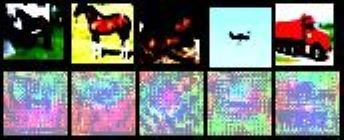

### VGG with CIFAR10

I was not able to train the VGG model as the time taken for a single epoch was around 35 hours.

### DenseNet with CIFAR10

In [ ]:
#@title
from tabulate import tabulate

print('\n\n CLASSIFICATION METRICS \n')
table = [["Epochs", "Accuracy", "F1-score", "Precision", "Recall"], [5, 0.4311, 0.4131, 0.4272, 0.4311]]
print(tabulate(table, tablefmt='fancy_grid'))
print('\n')



 CLASSIFICATION METRICS 

╒════════╤══════════╤══════════╤═══════════╤════════╕
│ Epochs │ Accuracy │ F1-score │ Precision │ Recall │
├────────┼──────────┼──────────┼───────────┼────────┤
│ 5      │ 0.4311   │ 0.4131   │ 0.4272    │ 0.4311 │
╘════════╧══════════╧══════════╧═══════════╧════════╛




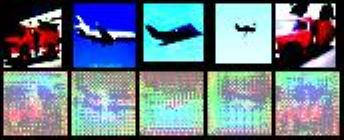

### InceptionNet with CIFAR10

In [ ]:
#@title
from tabulate import tabulate

print('\n\n CLASSIFICATION METRICS \n')
table = [["Epochs", "Accuracy", "F1-score", "Precision", "Recall"], [5, 0.3471, 0.2962,  0.2726, 0.3471]]
print(tabulate(table, tablefmt='fancy_grid'))
print('\n')



 CLASSIFICATION METRICS 

╒════════╤══════════╤══════════╤═══════════╤════════╕
│ Epochs │ Accuracy │ F1-score │ Precision │ Recall │
├────────┼──────────┼──────────┼───────────┼────────┤
│ 5      │ 0.3471   │ 0.2962   │ 0.2726    │ 0.3471 │
╘════════╧══════════╧══════════╧═══════════╧════════╛




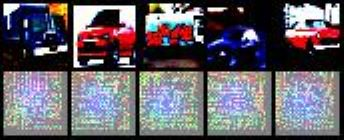